# Hierarchical 3D Medical Image Classification

This notebook trains a hierarchical classification model on **all 5 merged 3D MedMNIST datasets**:
- **OrganMNIST3D** (11 classes, multi-region)
- **NoduleMNIST3D** (2 classes, chest)
- **AdrenalMNIST3D** (2 classes, abdomen)
- **FractureMNIST3D** (3 classes, chest)
- **VesselMNIST3D** (2 classes, brain)

## Training Pipeline
1. **Stage 1 (Coarse)**: Classify anatomical region (abdomen, chest, brain)
2. **Stage 2 (Fine)**: Classify pathology within each region

In [1]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from config import (
    DEVICE, DATA_CONFIG, MODEL_CONFIG, TRAINING_CONFIG,
    PATHS, set_seed, DEFAULT_MERGED_DATASETS
)
from utils.data_loader import create_hierarchical_dataset
from utils.hierarchical_model import HierarchicalClassificationModel
from utils.trainer import HierarchicalTrainer
from utils.visualization import plot_training_history

set_seed(42)
print(f"Device: {DEVICE}")

GPU detected: NVIDIA GeForce RTX 3070
GPU memory: 8.21 GB
Platform: NVIDIA CUDA
Device: cuda


## 1. Load Merged Dataset

In [2]:
# Load all 5 merged datasets
print(f"Loading datasets: {DEFAULT_MERGED_DATASETS}")

train_loader, val_loader, test_loader, dataset_info = create_hierarchical_dataset(
    datasets_to_include=DEFAULT_MERGED_DATASETS,
    batch_size=DATA_CONFIG['batch_size'],
    num_workers=DATA_CONFIG['num_workers']
)

print("\n" + "="*60)
print("MERGED DATASET INFO")
print("="*60)
print(f"Datasets: {dataset_info['datasets_included']}")
print(f"Train samples: {dataset_info['train_samples']:,}")
print(f"Val samples: {dataset_info['val_samples']:,}")
print(f"Test samples: {dataset_info['test_samples']:,}")
print(f"\nCoarse classes (regions): {dataset_info['num_coarse_classes']}")
print(f"Region mapping: {dataset_info['idx_to_region']}")
print(f"Fine classes: {dataset_info['num_fine_classes']}")

Loading datasets: ['organ', 'nodule', 'adrenal', 'fracture', 'vessel']
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/fracturemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/adrenalmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/fracturemnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/nodulemnist3d.npz
Using downloaded and verif

In [3]:
# Verify data format
print("\nVerifying data format...")
for imgs, coarse_labels, fine_labels in train_loader:
    print(f"  Image shape: {imgs.shape}")
    print(f"  Coarse labels: {coarse_labels.shape} - unique: {coarse_labels.unique().tolist()}")
    print(f"  Fine labels: {fine_labels.shape} - unique: {fine_labels.unique().tolist()[:10]}...")
    break
print(" Data format verified!")


Verifying data format...
  Image shape: torch.Size([8, 1, 28, 28, 28])
  Coarse labels: torch.Size([8]) - unique: [0, 1, 2]
  Fine labels: torch.Size([8]) - unique: [0, 1, 2, 3, 4, 8]...
 Data format verified!


## 2. Build Hierarchical Model

The model consists of:
- **Coarse Classifier**: Shared 3D CNN backbone + region classification head
- **Fine Classifiers**: Separate classifier for each region

In [4]:
# Configure region-specific classes
# Each region has a different number of fine-grained classes
region_configs = dataset_info['region_num_classes']

# Get region index mapping from dataset
region_idx_to_name = dataset_info['idx_to_region']

print("Region configurations:")
for region, num_classes in region_configs.items():
    print(f"  {region}: {num_classes} classes")

Region configurations:
  abdomen: 10 classes
  chest: 8 classes
  brain: 2 classes


In [5]:
# Create hierarchical model
model = HierarchicalClassificationModel(
    region_configs=region_configs,
    architecture=MODEL_CONFIG['architecture'],
    coarse_model_type=MODEL_CONFIG['coarse_architecture'],
    fine_model_type=MODEL_CONFIG['fine_architecture'],
    dropout_rate=MODEL_CONFIG['dropout_rate'],
    region_idx_to_name=region_idx_to_name,
    num_total_organs=dataset_info['num_fine_classes'],
    use_subtypes=False
).to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel created:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Coarse architecture: {MODEL_CONFIG['coarse_architecture']}")
print(f"  Fine architecture: {MODEL_CONFIG['fine_architecture']}")


Model created:
  Total parameters: 132,651,799
  Trainable parameters: 132,651,799
  Coarse architecture: resnet18_3d
  Fine architecture: resnet18_3d


## 3. Train Hierarchical Model

Training proceeds in two stages:
1. **Stage 1**: Train coarse classifier to predict anatomical regions
2. **Stage 2**: Freeze coarse classifier, train region-specific fine classifiers

In [6]:
# Create trainer
trainer = HierarchicalTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    coarse_weight=0.3,
    fine_weight=0.7
)

print(f"Training configuration:")
print(f"  Coarse epochs: {TRAINING_CONFIG['coarse_epochs']}")
print(f"  Fine epochs: {TRAINING_CONFIG['fine_epochs']}")
print(f"  Learning rate: {TRAINING_CONFIG['learning_rate']}")

Training configuration:
  Coarse epochs: 20
  Fine epochs: 30
  Learning rate: 0.001


In [7]:
# Train the model
history = trainer.train(
    coarse_epochs=TRAINING_CONFIG['coarse_epochs'],
    fine_epochs=TRAINING_CONFIG['fine_epochs']
)

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)


=== Training Stage 1: Coarse Anatomical Classifier ===


Epoch 1: 100%|██████████| 710/710 [00:13<00:00, 51.12it/s]


Epoch 1: Loss=0.6917, Acc=0.7184


Epoch 2: 100%|██████████| 710/710 [00:13<00:00, 53.67it/s]


Epoch 2: Loss=0.4328, Acc=0.8343


Epoch 3: 100%|██████████| 710/710 [00:13<00:00, 52.94it/s]


Epoch 3: Loss=0.3440, Acc=0.8651


Epoch 4: 100%|██████████| 710/710 [00:13<00:00, 53.43it/s]


Epoch 4: Loss=0.3249, Acc=0.8797


Epoch 5: 100%|██████████| 710/710 [00:13<00:00, 53.18it/s]


Epoch 5: Loss=0.2628, Acc=0.9060


Epoch 6: 100%|██████████| 710/710 [00:13<00:00, 52.93it/s]


Epoch 6: Loss=0.2339, Acc=0.9109


Epoch 7: 100%|██████████| 710/710 [00:13<00:00, 53.13it/s]


Epoch 7: Loss=0.2332, Acc=0.9155


Epoch 8: 100%|██████████| 710/710 [00:13<00:00, 53.48it/s]


Epoch 8: Loss=0.1983, Acc=0.9260


Epoch 9: 100%|██████████| 710/710 [00:13<00:00, 52.99it/s]


Epoch 9: Loss=0.1836, Acc=0.9331


Epoch 10: 100%|██████████| 710/710 [00:13<00:00, 51.70it/s]


Epoch 10: Loss=0.1810, Acc=0.9345


Epoch 11: 100%|██████████| 710/710 [00:12<00:00, 55.08it/s]


Epoch 11: Loss=0.1579, Acc=0.9445


Epoch 12: 100%|██████████| 710/710 [00:12<00:00, 55.22it/s]


Epoch 12: Loss=0.1714, Acc=0.9407


Epoch 13: 100%|██████████| 710/710 [00:13<00:00, 54.32it/s]


Epoch 13: Loss=0.1412, Acc=0.9500


Epoch 14: 100%|██████████| 710/710 [00:14<00:00, 50.49it/s]


Epoch 14: Loss=0.1529, Acc=0.9479


Epoch 15: 100%|██████████| 710/710 [00:13<00:00, 50.93it/s]


Epoch 15: Loss=0.1286, Acc=0.9537


Epoch 16: 100%|██████████| 710/710 [00:13<00:00, 51.49it/s]


Epoch 16: Loss=0.1322, Acc=0.9544


Epoch 17: 100%|██████████| 710/710 [00:13<00:00, 53.19it/s]


Epoch 17: Loss=0.1280, Acc=0.9547


Epoch 18: 100%|██████████| 710/710 [00:13<00:00, 52.87it/s]


Epoch 18: Loss=0.1318, Acc=0.9523


Epoch 19: 100%|██████████| 710/710 [00:13<00:00, 50.93it/s]


Epoch 19: Loss=0.1255, Acc=0.9523


Epoch 20: 100%|██████████| 710/710 [00:13<00:00, 51.43it/s]


Epoch 20: Loss=0.1249, Acc=0.9562

=== Training Stage 2: Fine Pathology Classifiers ===
Freezing Stage 1 (coarse classifier)...


Epoch 1: 100%|██████████| 710/710 [00:35<00:00, 20.26it/s]


Epoch 1 Results:
  abdomen: Loss=1.8567, Acc=0.4357
  chest: Loss=1.7752, Acc=0.3772
  brain: Loss=0.4520, Acc=0.8644
  Overall: Loss=1.4927, Acc=0.5122


Epoch 2: 100%|██████████| 710/710 [00:33<00:00, 21.06it/s]


Epoch 2 Results:
  abdomen: Loss=1.7615, Acc=0.4503
  chest: Loss=1.5520, Acc=0.4201
  brain: Loss=0.4081, Acc=0.8749
  Overall: Loss=1.3565, Acc=0.5376


Epoch 3: 100%|██████████| 710/710 [00:33<00:00, 21.27it/s]


Epoch 3 Results:
  abdomen: Loss=1.6608, Acc=0.4704
  chest: Loss=1.7015, Acc=0.3730
  brain: Loss=0.4162, Acc=0.8734
  Overall: Loss=1.3851, Acc=0.5247


Epoch 4: 100%|██████████| 710/710 [00:33<00:00, 21.07it/s]


Epoch 4 Results:
  abdomen: Loss=1.7121, Acc=0.4518
  chest: Loss=1.6543, Acc=0.3755
  brain: Loss=0.4207, Acc=0.8697
  Overall: Loss=1.3846, Acc=0.5184


Epoch 5: 100%|██████████| 710/710 [00:33<00:00, 21.29it/s]


Epoch 5 Results:
  abdomen: Loss=1.6967, Acc=0.4422
  chest: Loss=1.5860, Acc=0.3849
  brain: Loss=0.3881, Acc=0.8742
  Overall: Loss=1.3432, Acc=0.5200


Epoch 6: 100%|██████████| 710/710 [00:32<00:00, 21.57it/s]


Epoch 6 Results:
  abdomen: Loss=1.5915, Acc=0.4774
  chest: Loss=1.5378, Acc=0.4074
  brain: Loss=0.3825, Acc=0.8831
  Overall: Loss=1.2850, Acc=0.5438


Epoch 7: 100%|██████████| 710/710 [00:33<00:00, 21.19it/s]


Epoch 7 Results:
  abdomen: Loss=1.5217, Acc=0.4920
  chest: Loss=1.5814, Acc=0.4218
  brain: Loss=0.3918, Acc=0.8772
  Overall: Loss=1.2808, Acc=0.5534


Epoch 8: 100%|██████████| 710/710 [00:33<00:00, 21.36it/s]


Epoch 8 Results:
  abdomen: Loss=1.5128, Acc=0.4950
  chest: Loss=1.5803, Acc=0.4036
  brain: Loss=0.3777, Acc=0.8801
  Overall: Loss=1.2739, Acc=0.5476


Epoch 9: 100%|██████████| 710/710 [00:33<00:00, 21.42it/s]


Epoch 9 Results:
  abdomen: Loss=1.5512, Acc=0.4834
  chest: Loss=1.4780, Acc=0.4405
  brain: Loss=0.3697, Acc=0.8831
  Overall: Loss=1.2431, Acc=0.5596


Epoch 10: 100%|██████████| 710/710 [00:33<00:00, 21.31it/s]


Epoch 10 Results:
  abdomen: Loss=1.4626, Acc=0.5000
  chest: Loss=1.4178, Acc=0.4516
  brain: Loss=0.3763, Acc=0.8839
  Overall: Loss=1.1886, Acc=0.5702


Epoch 11: 100%|██████████| 710/710 [00:33<00:00, 21.29it/s]


Epoch 11 Results:
  abdomen: Loss=1.4428, Acc=0.4935
  chest: Loss=1.4257, Acc=0.4609
  brain: Loss=0.3778, Acc=0.8839
  Overall: Loss=1.1854, Acc=0.5718


Epoch 12: 100%|██████████| 710/710 [00:33<00:00, 21.16it/s]


Epoch 12 Results:
  abdomen: Loss=1.4421, Acc=0.4910
  chest: Loss=1.4356, Acc=0.4601
  brain: Loss=0.3878, Acc=0.8854
  Overall: Loss=1.1916, Acc=0.5709


Epoch 13: 100%|██████████| 710/710 [00:34<00:00, 20.37it/s]


Epoch 13 Results:
  abdomen: Loss=1.4643, Acc=0.5055
  chest: Loss=1.4633, Acc=0.4286
  brain: Loss=0.3762, Acc=0.8861
  Overall: Loss=1.2081, Acc=0.5631


Epoch 14: 100%|██████████| 710/710 [00:34<00:00, 20.86it/s]


Epoch 14 Results:
  abdomen: Loss=1.4245, Acc=0.5181
  chest: Loss=1.4804, Acc=0.4252
  brain: Loss=0.3730, Acc=0.8846
  Overall: Loss=1.2005, Acc=0.5658


Epoch 15: 100%|██████████| 710/710 [00:34<00:00, 20.84it/s]


Epoch 15 Results:
  abdomen: Loss=1.4444, Acc=0.4970
  chest: Loss=1.3708, Acc=0.4605
  brain: Loss=0.3713, Acc=0.8876
  Overall: Loss=1.1617, Acc=0.5737


Epoch 16: 100%|██████████| 710/710 [00:34<00:00, 20.41it/s]


Epoch 16 Results:
  abdomen: Loss=1.4244, Acc=0.4990
  chest: Loss=1.4440, Acc=0.4550
  brain: Loss=0.3684, Acc=0.8876
  Overall: Loss=1.1843, Acc=0.5721


Epoch 17: 100%|██████████| 710/710 [00:34<00:00, 20.84it/s]


Epoch 17 Results:
  abdomen: Loss=1.3631, Acc=0.5241
  chest: Loss=1.5008, Acc=0.4150
  brain: Loss=0.3704, Acc=0.8861
  Overall: Loss=1.1868, Acc=0.5640


Epoch 18: 100%|██████████| 710/710 [00:34<00:00, 20.45it/s]


Epoch 18 Results:
  abdomen: Loss=1.3699, Acc=0.5111
  chest: Loss=1.4725, Acc=0.4142
  brain: Loss=0.3716, Acc=0.8854
  Overall: Loss=1.1777, Acc=0.5589


Epoch 19: 100%|██████████| 710/710 [00:33<00:00, 20.90it/s]


Epoch 19 Results:
  abdomen: Loss=1.4820, Acc=0.4950
  chest: Loss=1.4168, Acc=0.4601
  brain: Loss=0.3834, Acc=0.8869
  Overall: Loss=1.1967, Acc=0.5726


Epoch 20: 100%|██████████| 710/710 [00:33<00:00, 21.03it/s]


Epoch 20 Results:
  abdomen: Loss=1.4703, Acc=0.4995
  chest: Loss=1.5094, Acc=0.4261
  brain: Loss=0.3765, Acc=0.8861
  Overall: Loss=1.2294, Acc=0.5600


Epoch 21: 100%|██████████| 710/710 [00:34<00:00, 20.73it/s]


Epoch 21 Results:
  abdomen: Loss=1.4989, Acc=0.4960
  chest: Loss=1.4616, Acc=0.4448
  brain: Loss=0.3630, Acc=0.8869
  Overall: Loss=1.2164, Acc=0.5666


Epoch 22: 100%|██████████| 710/710 [00:35<00:00, 20.04it/s]


Epoch 22 Results:
  abdomen: Loss=1.4475, Acc=0.4930
  chest: Loss=1.3816, Acc=0.4690
  brain: Loss=0.3694, Acc=0.8869
  Overall: Loss=1.1668, Acc=0.5756


Epoch 23: 100%|██████████| 710/710 [00:34<00:00, 20.38it/s]


Epoch 23 Results:
  abdomen: Loss=1.4474, Acc=0.5035
  chest: Loss=1.3582, Acc=0.4703
  brain: Loss=0.3556, Acc=0.8876
  Overall: Loss=1.1538, Acc=0.5800


Epoch 24: 100%|██████████| 710/710 [00:34<00:00, 20.73it/s]


Epoch 24 Results:
  abdomen: Loss=1.4127, Acc=0.5101
  chest: Loss=1.4019, Acc=0.4652
  brain: Loss=0.3459, Acc=0.8869
  Overall: Loss=1.1574, Acc=0.5800


Epoch 25: 100%|██████████| 710/710 [00:33<00:00, 20.90it/s]


Epoch 25 Results:
  abdomen: Loss=1.3460, Acc=0.5196
  chest: Loss=1.3765, Acc=0.4554
  brain: Loss=0.3481, Acc=0.8839
  Overall: Loss=1.1241, Acc=0.5786


Epoch 26: 100%|██████████| 710/710 [00:33<00:00, 21.08it/s]


Epoch 26 Results:
  abdomen: Loss=1.4251, Acc=0.5126
  chest: Loss=1.2726, Acc=0.4979
  brain: Loss=0.3798, Acc=0.8861
  Overall: Loss=1.1161, Acc=0.5943


Epoch 27: 100%|██████████| 710/710 [00:33<00:00, 21.04it/s]


Epoch 27 Results:
  abdomen: Loss=1.4746, Acc=0.4985
  chest: Loss=1.2517, Acc=0.4800
  brain: Loss=0.3519, Acc=0.8876
  Overall: Loss=1.1183, Acc=0.5823


Epoch 28: 100%|██████████| 710/710 [00:34<00:00, 20.87it/s]


Epoch 28 Results:
  abdomen: Loss=1.4756, Acc=0.4985
  chest: Loss=1.3144, Acc=0.4754
  brain: Loss=0.3413, Acc=0.8861
  Overall: Loss=1.1422, Acc=0.5800


Epoch 29: 100%|██████████| 710/710 [00:34<00:00, 20.78it/s]


Epoch 29 Results:
  abdomen: Loss=1.3740, Acc=0.5236
  chest: Loss=1.2533, Acc=0.4847
  brain: Loss=0.3581, Acc=0.8854
  Overall: Loss=1.0852, Acc=0.5925


Epoch 30: 100%|██████████| 710/710 [00:33<00:00, 21.09it/s]

Epoch 30 Results:
  abdomen: Loss=1.3676, Acc=0.5236
  chest: Loss=1.2159, Acc=0.5042
  brain: Loss=0.3509, Acc=0.8876
  Overall: Loss=1.0657, Acc=0.6012

TRAINING COMPLETE!


## 4. Training Visualization

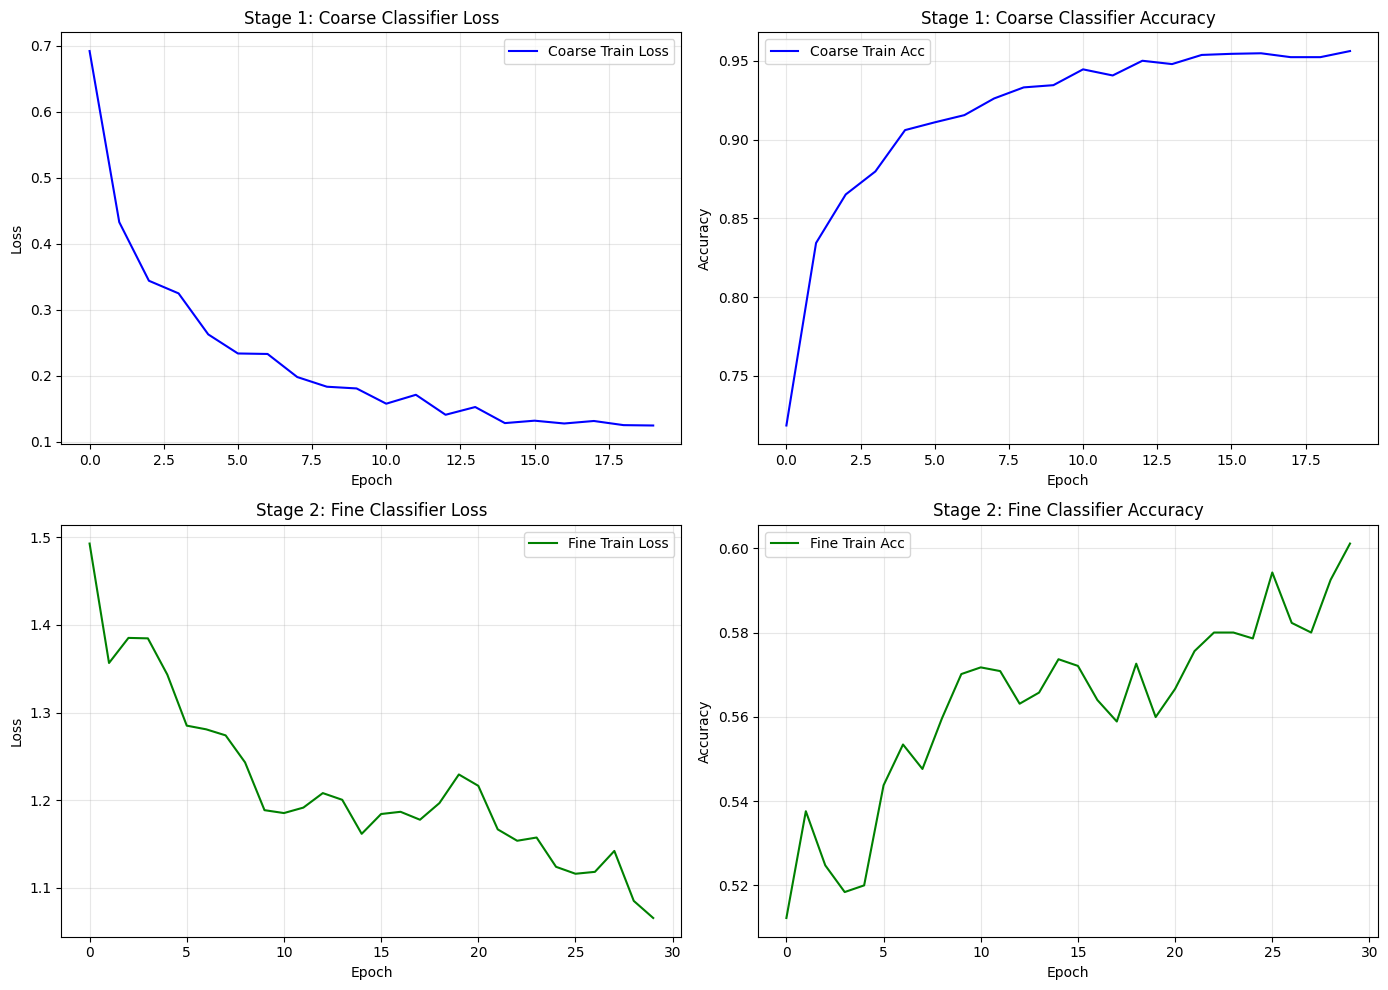

In [8]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Coarse training
if history['coarse_train_loss']:
    axes[0, 0].plot(history['coarse_train_loss'], label='Coarse Train Loss', color='blue')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Stage 1: Coarse Classifier Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

if history['coarse_train_acc']:
    axes[0, 1].plot(history['coarse_train_acc'], label='Coarse Train Acc', color='blue')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Stage 1: Coarse Classifier Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

# Fine training
if history['fine_train_loss']:
    axes[1, 0].plot(history['fine_train_loss'], label='Fine Train Loss', color='green')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_title('Stage 2: Fine Classifier Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

if history['fine_train_acc']:
    axes[1, 1].plot(history['fine_train_acc'], label='Fine Train Acc', color='green')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].set_title('Stage 2: Fine Classifier Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{PATHS['figures']}/hierarchical_training_{MODEL_CONFIG['architecture']}.png", dpi=150)
plt.show()

## 5. Evaluation on Test Set

In [9]:
def evaluate_hierarchical_model(model, test_loader, device, region_idx_to_name):
    """Evaluate hierarchical model on test set."""
    model.eval()
    
    coarse_correct = 0
    coarse_total = 0
    
    fine_correct = {name: 0 for name in region_idx_to_name.values()}
    fine_total = {name: 0 for name in region_idx_to_name.values()}
    
    all_coarse_preds = []
    all_coarse_labels = []
    all_fine_preds = []
    all_fine_labels = []
    
    with torch.no_grad():
        for imgs, coarse_labels, fine_labels in tqdm(test_loader, desc="Evaluating"):
            imgs = imgs.to(device, dtype=torch.float32)
            if imgs.max() > 1:
                imgs = imgs / 255.0
            
            coarse_labels = coarse_labels.long().to(device)
            fine_labels = fine_labels.long().to(device)
            
            # Stage 1: Coarse prediction
            coarse_logits = model.forward_coarse(imgs)
            coarse_preds = coarse_logits.argmax(1)
            
            coarse_correct += (coarse_preds == coarse_labels).sum().item()
            coarse_total += imgs.size(0)
            
            all_coarse_preds.extend(coarse_preds.cpu().numpy())
            all_coarse_labels.extend(coarse_labels.cpu().numpy())
            
            # Stage 2: Fine prediction per region
            for region_idx, region_name in region_idx_to_name.items():
                mask = (coarse_labels == region_idx)
                if not mask.any():
                    continue
                
                region_imgs = imgs[mask]
                region_fine_labels = fine_labels[mask]
                
                fine_logits = model.forward_fine(region_imgs, region_name)
                fine_preds = fine_logits.argmax(1)
                
                fine_correct[region_name] += (fine_preds == region_fine_labels).sum().item()
                fine_total[region_name] += region_imgs.size(0)
                
                all_fine_preds.extend(fine_preds.cpu().numpy())
                all_fine_labels.extend(region_fine_labels.cpu().numpy())
    
    # Compute metrics
    coarse_acc = coarse_correct / coarse_total if coarse_total > 0 else 0
    
    fine_acc_per_region = {}
    for region_name in region_idx_to_name.values():
        if fine_total[region_name] > 0:
            fine_acc_per_region[region_name] = fine_correct[region_name] / fine_total[region_name]
        else:
            fine_acc_per_region[region_name] = 0.0
    
    overall_fine_acc = sum(fine_correct.values()) / sum(fine_total.values()) if sum(fine_total.values()) > 0 else 0
    
    return {
        'coarse_accuracy': coarse_acc,
        'fine_accuracy_per_region': fine_acc_per_region,
        'overall_fine_accuracy': overall_fine_acc,
        'coarse_predictions': np.array(all_coarse_preds),
        'coarse_labels': np.array(all_coarse_labels),
        'fine_predictions': np.array(all_fine_preds),
        'fine_labels': np.array(all_fine_labels),
    }

In [10]:
# Evaluate on test set
results = evaluate_hierarchical_model(model, test_loader, DEVICE, region_idx_to_name)

print("\n" + "="*60)
print("TEST SET RESULTS")
print("="*60)
print(f"\nStage 1 (Coarse) Accuracy: {results['coarse_accuracy']:.4f}")
print(f"\nStage 2 (Fine) Accuracy per Region:")
for region, acc in results['fine_accuracy_per_region'].items():
    print(f"  {region}: {acc:.4f}")
print(f"\nOverall Fine Accuracy: {results['overall_fine_accuracy']:.4f}")

Evaluating: 100%|██████████| 230/230 [00:02<00:00, 107.04it/s]


TEST SET RESULTS

Stage 1 (Coarse) Accuracy: 0.9598

Stage 2 (Fine) Accuracy per Region:
  abdomen: 0.4707
  chest: 0.5799
  brain: 0.8874

Overall Fine Accuracy: 0.5962


## 6. Save Model

In [11]:
import os
os.makedirs(PATHS['models'], exist_ok=True)

# Save model
model_path = f"{PATHS['models']}/hierarchical_{MODEL_CONFIG['architecture']}.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'region_configs': region_configs,
    'dataset_info': dataset_info,
    'history': history,
    'test_results': results,
    'config': {
        'coarse_architecture': MODEL_CONFIG['coarse_architecture'],
        'fine_architecture': MODEL_CONFIG['fine_architecture'],
        'dropout_rate': MODEL_CONFIG['dropout_rate'],
    }
}, model_path)

print(f"\n Model saved to: {model_path}")


 Model saved to: /home/luca/HierarchicalMIC/models/hierarchical_resnet18_3d.pth


## 7. Summary

In [12]:
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"\nDatasets used: {', '.join(dataset_info['datasets_included'])}")
print(f"Total training samples: {dataset_info['train_samples']:,}")
print(f"\nModel architecture:")
print(f"  Coarse: {MODEL_CONFIG['coarse_architecture']}")
print(f"  Fine: {MODEL_CONFIG['fine_architecture']}")
print(f"  Total parameters: {total_params:,}")
print(f"\nFinal Results:")
print(f"  Coarse accuracy: {results['coarse_accuracy']:.4f}")
print(f"  Fine accuracy: {results['overall_fine_accuracy']:.4f}")
print(f"\nModel saved to: {model_path}")


TRAINING SUMMARY

Datasets used: organ, nodule, adrenal, fracture, vessel
Total training samples: 5,679

Model architecture:
  Coarse: resnet18_3d
  Fine: resnet18_3d
  Total parameters: 132,651,799

Final Results:
  Coarse accuracy: 0.9598
  Fine accuracy: 0.5962

Model saved to: /home/luca/HierarchicalMIC/models/hierarchical_resnet18_3d.pth
